### 다층 퍼셉트론의 한계
다층 퍼셉트론의 학습이 가능해지면서 층을 깊이 쌓기만 하면 복잡한 기능을 하는 신경망 모델을 만들어낼 수 있을 것이라 기대했다.  
하지만 층을 깊이 쌓을수록 더 정교해지기보다는 학습을 하지 못하는 모델이 되어갔다.  
이것은 경사하강법을 통해 오차를 줄여가는 과정이 제대로 동작하지 않았기 때문인데,  
출력 근처에서는 오차를 반영하여 가중치를 조절했지만, 역전파될수록 점점 신호가 소실되는 vanishing gradient 문제가 발생하거나  
역전파될수록 점점 신호가 커지는 exploding gradient 문제가 발생한 것이다.  

#### 범인1. 활성화함수 
+ sigmoid 함수는 비대칭 함수로, 값이 0 또는 1에 가까워지면 그 미분값은 0에 가까워지므로,  
아래 단계로 오차를 제대로 전파하지 못하고, 결국 학습이 제대로 이루어지지 않는다.  
=> 활성화함수를 tanh같은 대칭 함수를 사용해 활성화함수 값이 0이어도 오차를 잘 전달해 줄 수 있도록 한다.
+ 과거 여러 층을 겹쳐 신경망을 구현 시 일반적으로 사용하던 sigmoid 함수 말고 다양한 활성화함수를 적용하는 시도들이 등장했다.
+ ReLU는 양수 입력은 그대로 내보내고, 음수 입력은 0을 출력해 기울기 소실 문제는 피하면서 계산 효율이 높다.  

#### 범인2. 가중치 초기화 방법
+ 각 계층의 노드 수가 달라지면, 입력->출력의 순전파 신호, 출력->입력의 오차 역전파 신호의 분산이 왜곡돼 전달되므로 기울기소실/폭발 문제가 발생한다.
+ 따라서 각 은닉층의 크기가 동일하면 좋지만, 실제로 그러긴 힘들다. 
+ Keras에서는 디폴트로 glorot_uniform(=Xavier initialization) 방법으로 초기화해준다.
+ 다양한 활성화함수를 시도해보면서 초기화는 활성화함수의 특성에 따라 다르게 설정되어야 한다는 것도 알게 되었다.
+ 신경망의 층이 늘어날수록 ReLU와 같은 정류화 함수(rectifiers)들이 더 잘 동작하는 것도 알게 되었다.
+ ReLU 활성화함수를 사용할 때 glorot_uniform보다 He(허) 초기화가 더 빠르게 수렴한다.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)      #60000개의 28*28 데이터
print(x_train[0].shape)   #0-255 사이의 값 28*28(784)개
print(y_train.shape)      #레이블은 0-9 사이의 값

(60000, 28, 28)
(28, 28)
(60000,)


In [28]:
#x_train[0]의 값들을 모두 출력해보자
num = x_train[0]
for i in range(28):
    for j in range(28):
        print('{:3d}'.format(num[i][j]), end='')
    print()

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  3 18 18 18126136175 26166255247127  0  0  0  0
  0  0  0  0  0  0  0  0 30 36 94154170253253253253253225172253242195 64  0  0  0  0
  0  0  0  0  0  0  0 49238253253253253253253253253251 93 82 82 56 39  0  0  0  0  0
  0  0  0  0  0  0  0 18219253253253253253198182247241  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 80156107253253205 11  0 43154  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 14  1154253 90  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0139253190  2  0  0  0  0  0  0  

label = 5


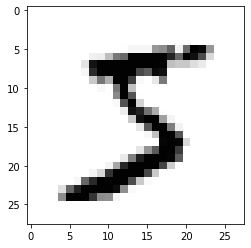

In [29]:
print(f'label = {y_train[0]}')
plt.imshow(num, cmap='Greys', interpolation='nearest');

### MNIST 데이터로 Keras 이용하기
1. x_train 데이터를 심층 신경망 모델에 넣어 y_train의 레이블로 인식하도록 학습시키기
2. 이 때 노드의 활성화함수, 학습을 위한 최적화함수, 손실함수, 측정방법 지정하기
    + 분류문제에서 출력층의 최적화함수는 softmax(가중치 벡터를 클래스별 확률값(0-1)으로 변환)
3. 학습된 모델에 x_test 데이터를 넣어 모델의 정확도 알아보기

In [36]:
#0-255 사이 값을 0-1 사이 값이 되도록 정규화
#인공신경망의 전체 수식에서 사용되는 값이 float값이기 때문에 정규화를 통해 입력을 float로 맞춰 더 나은 결과를 얻을 수 있음
x_train = x_train / 255
x_test = x_test / 255

model = keras.models.Sequential([keras.layers.Flatten(input_shape=(28,28)),       #28*28 배열을 784*1로 펼침ㅠ
                                 keras.layers.Dense(256, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')])   #레이블이 10개로 분류해야하기 때문

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#학습과정에서 학습데이터/검증데이터에 대해 측정된 accuracy, loss를 history에 저장
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9650 - accuracy: 0.7726 - val_loss: 0.4693 - val_accuracy: 0.8799
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4040 - accuracy: 0.8908 - val_loss: 0.3429 - val_accuracy: 0.9056
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3350 - accuracy: 0.9050 - val_loss: 0.3075 - val_accuracy: 0.9126
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3055 - accuracy: 0.9124 - val_loss: 0.2872 - val_accuracy: 0.9171
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2857 - accuracy: 0.9180 - val_loss: 0.2706 - val_accuracy: 0.9200
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2693 - accuracy: 0.9220 - val_loss: 0.2566 - val_accuracy: 0.9241
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2545 - accuracy: 0.9261 - val_loss: 0.2501 - val_accuracy:

In [31]:
model.summary()
#입력 784개(+편향값 1개) * 은닉층 256개 = 200960
#은닉층 256개(+편향값 1개) * 은닉층 10개 = 2570
#200960 + 2570 = 총 253530개의 파라미터를 학습

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               200960    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.evaluate(x_test, y_test)  #각각 loss, compile의 metrics(지금은 accuracy)를 나타냄

313/313 [==============================] - 1s 1ms/step - loss: 0.0832 - accuracy: 0.9801


[0.0831981673836708, 0.9800999760627747]

<AxesSubplot:>

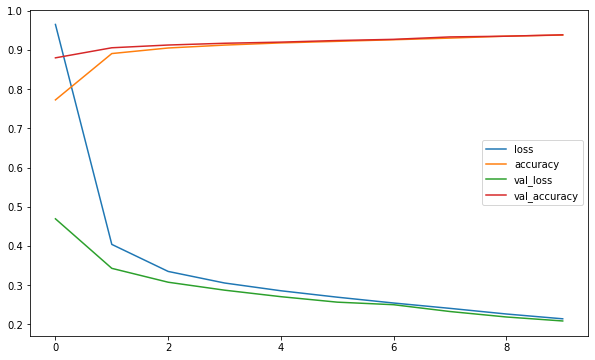

In [37]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10,6))

### 원핫인코딩
벡터 출력값이 스칼라 형식의 정답과 얼마만큼 차이나는지 정량화하기 어렵기 때문에 원핫인코딩을 사용할 수 있다.
1. 각 레이블에 고유 인덱스를 부여한다.
2. 표현하고자하는 레이블의 인덱스 위치에 1, 나머지 인덱스에 0을 부여한다.

=> keras.utils의 to_categorical 함수 사용

In [ ]:
from tensorflow.keras.utils import to_categorical

data = np.array([0,1,2,3,4])
print('원본 데이터 :', data)

encoded_data = to_categorical(data)
print('인코딩 후 :\n', encoded_data)

원본 데이터 : [0 1 2 3 4]
인코딩 후 :
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
#정답레이블이 3일 때, 모델이 출력한 예측(벡터)와 비교해 오차 구해보기
target = np.array([0, 0, 0, 1, 0])
correct_y_pred = np.array([0.005, 0.173, 0.035, 0.777, 0.01])   #3의 확률이 77.7%로 가장 높긴 함
wrong_y_pred = np.array([0.2, 0.3, 0.4, 0.01, 0.09])

def mse(y, t):  #평균제곱오차
    return ((y-t)**2).mean()

print('맞을 확률이 높을 때 MSE :', mse(correct_y_pred, target))
print('맞을 확률이 낮을 때 MSE :', mse(wrong_y_pred, target))   #정답에서 많이 벗어날수록 큰 오차값 출력 => 가중치 업데이트를 더 많이해 학습이 제대로 이루어질 것

맞을 확률이 높을 때 MSE : 0.016201599999999997
맞을 확률이 낮을 때 MSE : 0.25564


### cross_entropy_error
+ 분류모델의 레이블이 원핫인코딩으로 구성된 경우에만 사용 가능하다.

In [ ]:
def cee(y, t):
    delta = 1e-7   #분모가 0이 되지 않도록 작은 마진값 설정
    return -np.sum(t * np.log(y+delta))

target = np.array([0, 0, 0, 1, 0])
correct_y_pred = np.array([0.005, 0.173, 0.035, 0.777, 0.01])   #3의 확률이 77.7%로 가장 높긴 함
wrong_y_pred = np.array([0.2, 0.3, 0.4, 0.01, 0.09])

print('맞을 확률이 높을 때 CEE :', cee(correct_y_pred, target))
print('맞을 확률이 낮을 때 CEE :', cee(wrong_y_pred, target))  
print('비율 :', cee(wrong_y_pred, target) / cee(correct_y_pred, target))
print()
print('맞을 확률이 높을 때 MSE :', mse(correct_y_pred, target))
print('맞을 확률이 낮을 때 MSE :', mse(wrong_y_pred, target))
print('비율 :', mse(wrong_y_pred, target) / mse(correct_y_pred, target))

맞을 확률이 높을 때 CEE : 0.2523147999143692
맞을 확률이 낮을 때 CEE : 4.605160186038091
비율 : 18.251645117928057

맞을 확률이 높을 때 MSE : 0.016201599999999997
맞을 확률이 낮을 때 MSE : 0.25564
비율 : 15.778688524590166


맞았을 때/틀렸을 때의 오차 비율을 확인해보면 cross entropy error를 사용했을 때가 더 높다.  
학습은 오차를 줄여나가는 과정이기 때문에, 더 큰 패널티를 부여하는 cross entropy error를 신경망의 오차로 사용하면  
학습속도를 더 높일 수 있고, 오답 레이블과의 오차는 구하지 않으므로 분류할 레이블이 많아질수록 계산량이 줄어든다.

### 정규화 & 표준화
머신러닝에서 사용되는 데이터 값 중에서 균일한 scale을 가지지 않는 경우가 많다.  
그런 경우 더 큰 스케일을 가지는 특징에 의해 예측값이 좌우될 가능성이 크다.  
따라서 특징들 모두 0-1(MinMaxScaler) 사이 값 등으로 변환시켜주는 것이 바람직할 것이다.
+ 정규화(normalization)
    + MinMaxScaler의 경우 min(x)~max(x)가 0~1이 되도록 조정
+ 표준화(standardization)
    + StandardScaler의 경우 데이터가 평균이 0이고 표준편차가 1인 정규분포를 가지도록 조정

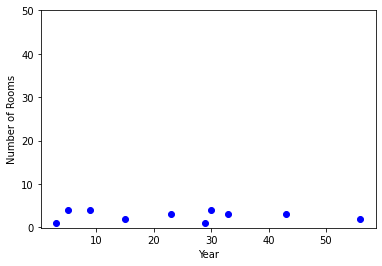

In [ ]:
from sklearn.preprocessing import MinMaxScaler

year = np.array([15, 30, 23, 5, 9, 43, 33, 29, 3, 56])  #(10,)
rooms = np.array([2, 4, 3, 4, 4, 3, 3, 1, 1, 2])        #(10,)

plt.scatter(year, rooms, c='b')
plt.ylim(-0.1, 50)
plt.xlabel('Year')
plt.ylabel('Number of Rooms');

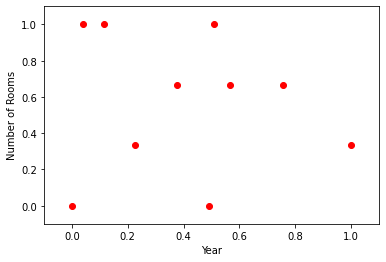

In [ ]:
scaler = MinMaxScaler()
year_norm = scaler.fit_transform(year[:, np.newaxis])   #(10, 1)
rooms_norm = scaler.fit_transform(rooms[:, np.newaxis]) #(10, 1)

plt.scatter(year_norm, rooms_norm, c='r')
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)
plt.xlabel('Year')
plt.ylabel('Number of Rooms');

### 배치정규화 & 배치경사하강법
+ 배치정규화 : 학습과정에서 신경망 가중치 값들의 분포를 조절하는 방법
    + keras.layers.normalization의 BatchNormalization 함수 사용 가능
+ 배치경사하강법 : 가중치 업데이트를 위해 학습데이터 개수를 조절하는 방법


### Drop out(희석화)
과적합 문제를 해결하기 위해 학습 단계에서 임의의 노드를 탈락시켜 학습하는 방법이다.  
오차율을 줄일 수 있고, 수행속도 면에서도 유리하다.  
=> keras.layers의 Dropout 함수 사용

In [38]:
data = np.arange(1, 11).reshape(2, 5).astype(np.float32)

data

array([[ 1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10.]], dtype=float32)

In [43]:
layer = tf.keras.layers.Dropout(0.3, input_shape=(2,))   #dropout 확률 0.3으로 지정
outputs = layer(data, training=True)                     #dropout 적용해 훈련 진행

outputs   #10개 중 30%를 매번 탈락시키는 것이 아니라, 각각의 탈락확률이 30%이므로 수행마다 0의 개수는 달라짐

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[ 0.      ,  2.857143,  4.285714,  5.714286,  0.      ],
       [ 0.      , 10.      ,  0.      , 12.857143, 14.285715]],
      dtype=float32)>

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.0687 - accuracy: 0.7221 - val_loss: 0.5045 - val_accuracy: 0.8769
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4773 - accuracy: 0.8655 - val_loss: 0.3698 - val_accuracy: 0.9016
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3966 - accuracy: 0.8842 - val_loss: 0.3197 - val_accuracy: 0.9116
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3593 - accuracy: 0.8942 - val_loss: 0.2917 - val_accuracy: 0.9166
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3328 - accuracy: 0.9021 - val_loss: 0.2694 - val_accuracy: 0.9211
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3142 - accuracy: 0.9073 - val_loss: 0.2523 - val_accuracy: 0.9254
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2929 - accuracy: 0.9136 - val_loss: 0.2362 - val_accuracy:

<AxesSubplot:>

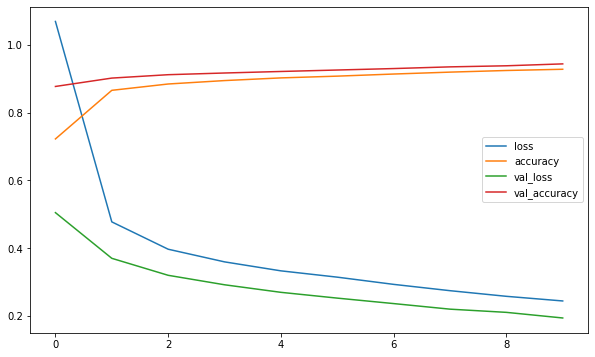

In [44]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=(28,28)),    
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Dense(256, activation='relu'),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Dense(10, activation='softmax')])  

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test))

pd.DataFrame(history.history).plot(figsize=(10,6))
#dropout 사용 전에 비해 훈련데이터보다 검증데이터에 대한 정확도가 높고, loss가 줄어드는 것을 볼 수 있다.

### Quiz.
Keras의 fashion_mnist 데이터셋을 이용해 신경망을 생성하고 학습시킨 다음, 정확도를 구해보자.
+ 128, 32개의 노드를 가진 2개의 은닉층
+ 입력층에서 128개 노드의 은닉층으로 갈 때 20% 드롭아웃 사용
+ 10개의 출력노드 각각의 10개의 클래스에 해당

In [61]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

labels : [9 0 0]


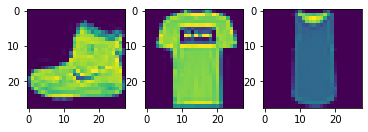

In [50]:
#x_train의 1-3번째 데이터 확인
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)   #1*3칸 중 1번째칸에 그려넣음
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

print('labels :', y_train[:3])
ax1.imshow(x_train[0])
ax2.imshow(x_train[1])
ax3.imshow(x_train[2]);

In [62]:
#정규화
x_train = x_train / 255
x_test = x_test / 255

model = keras.models.Sequential([keras.layers.Flatten(input_shape=(28,28)),
                                 keras.layers.Dropout(0.2),
                                 keras.layers.Dense(128, activation='relu'),
                                 keras.layers.Dense(32, activation='relu'),
                                 keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, 
                    batch_size=64, validation_split=0.25)    #k-fold(0.75는 훈련에, 0.25는 검증에 사용하는) 교차검증

Epoch 1/10
704/704 [==============================] - 2s 3ms/step - loss: 0.5985 - accuracy: 0.7880 - val_loss: 0.4372 - val_accuracy: 0.8443
Epoch 2/10
704/704 [==============================] - 2s 2ms/step - loss: 0.4397 - accuracy: 0.8426 - val_loss: 0.4076 - val_accuracy: 0.8511
Epoch 3/10
704/704 [==============================] - 2s 3ms/step - loss: 0.4004 - accuracy: 0.8527 - val_loss: 0.3780 - val_accuracy: 0.8643
Epoch 4/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3777 - accuracy: 0.8611 - val_loss: 0.3617 - val_accuracy: 0.8674
Epoch 5/10
704/704 [==============================] - 2s 2ms/step - loss: 0.3546 - accuracy: 0.8683 - val_loss: 0.3538 - val_accuracy: 0.8701
Epoch 6/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3445 - accuracy: 0.8725 - val_loss: 0.3548 - val_accuracy: 0.8753
Epoch 7/10
704/704 [==============================] - 2s 3ms/step - loss: 0.3322 - accuracy: 0.8751 - val_loss: 0.3336 - val_accuracy: 0.8779
Epoch 

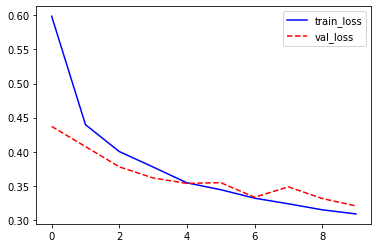

In [66]:
plt.plot(history.history['loss'], 'b-', label='train_loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.legend();

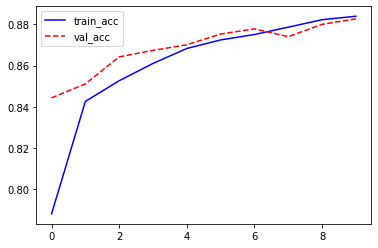

In [65]:
plt.plot(history.history['accuracy'], 'b-', label='train_acc')
plt.plot(history.history['val_accuracy'], 'r--', label='val_acc')
plt.legend();

In [67]:
#loss, accuracy 확인
model.evaluate(x_test, y_test)   

313/313 [==============================] - 1s 2ms/step - loss: 0.3469 - accuracy: 0.8733


[0.34689804911613464, 0.8733000159263611]

label : 5


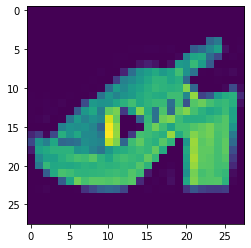

In [70]:
rand_idx = np.random.randint(0, 1000)
print('label :', y_test[rand_idx])
plt.imshow(x_test[rand_idx]);

In [73]:
img = x_test[rand_idx]              #(28,28) => 모델의 입력으로 사용하기 위해 (1, 28, 28) 형태로 변환 필요
input_img = img[np.newaxis, :, :]   #(1, 28, 28)

y_pred = model.predict(input_img)
print(y_pred.round(3))              #index5의 확률이 99.8%로 가장 높음

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.998, 0.   , 0.   , 0.   ,
        0.002]], dtype=float32)

In [75]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ancle boot']

label = np.argmax(y_pred)   #argmax 함수를 통해 가장 큰 값이 몇 번째 원소인지 확인 가능
class_names[label]

'Sandal'

In [76]:
def plot_images(images, labels, images_per_row=5):    #한줄에 이미지 5개씩
    n_images = len(images)
    n_rows = ((n_images-1) // images_per_row) + 1     #5개씩 몇줄이 될지 계산
    fig, ax = plt.subplots(n_rows, images_per_row, figsize=(images_per_row*2, n_rows*2))
    
    for i in range(n_rows):
        for j in range(images_per_row):
            if i*images_per_row + j > n_images:
                break
            img_idx = i*images_per_row + j
            a_image = images[img_idx].reshape(28,28)
            if n_rows > 1:
                axis = ax[i, j]
            else:
                axis = ax[j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            label = class_names[labels[img_idx]]
            axis.set_title(label)
            axis.imshow(a_image, interpolation='nearest')

In [77]:
images = x_test[:25]
preds = np.argmax(model.predict(images), axis=1)
preds

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0, 2, 5,
       7, 5, 1], dtype=int64)

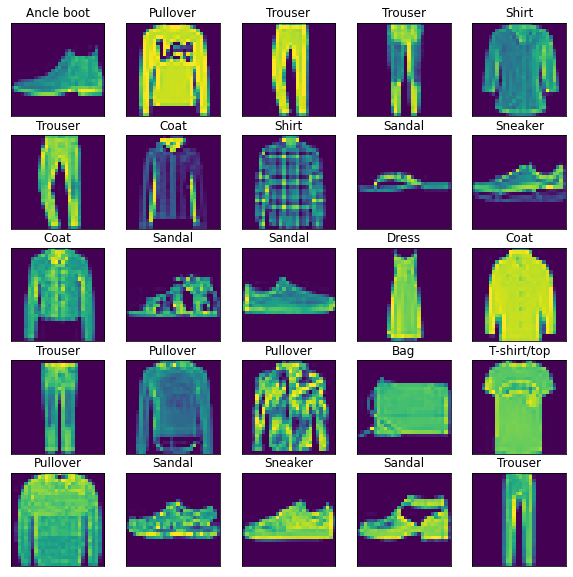

In [78]:
plot_images(images, preds)